In [1]:
import pickle
import base64
import json
import io
import csv
import os.path
import re
from datetime import datetime as dt

import warnings
warnings.simplefilter('ignore')
import inspect  # 引数名の取得に使う

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
import glob

files = glob.glob("./*")
for file in files:
    print(file)

./gmail_210919_copy_xxxxx.ipynb
./gmail_190101-201231.pickle
./mail.pickle
./client_id.json
./gmail_1000.pickle
./gmail_210919_copy.ipynb
./s0_gmail_credential.py
./token.pickle


In [3]:
# 2021年

if os.path.exists("mail.pickle"):
    with open("gmail_1000.pickle", "rb") as mail_gold_barrel_sales:
        messages21 = pickle.load(mail_gold_barrel_sales)



In [4]:
# 2019年 , 2020年  |  2019.01.01 - 2020.12.31

if os.path.exists("mail.pickle"):
    with open("gmail_190101-201231.pickle", "rb") as mail_gold_barrel_sales:
        messages19 = pickle.load(mail_gold_barrel_sales)



"""`
ファーマーズの毎日の売上累計メールの最終時刻が毎年変化している。
そのため、1日の最後の売上累計メールを選ぶには単純に時刻では選べない。

例えば、最終メールの送信時刻次の通りになっている。
2019年は 18:00
2020年は 19:00
2021年は 18:30

1日の間に届いたメールを全て比較して、送信時刻が最も遅いものを選ぶ
という判定を作る必要がある。

`
"""

In [5]:

def mail_to_df(l_messages, last_mail=True):

    # **********
    # df.appry() で body列 から単価と数量を分割するための関数
    def f_div_price_quantity(data_,div_ , p_q):
        if p_q == 'price': p_q = 0
        if p_q == 'quantity': p_q = 1
        return int(''.join(re.findall(r"\d+", data_.split(div_)[p_q])))

    # **********
    # まずは売上と値引を分割してリスト配列にし、これを body2 とする
    def f_div_sales_F_discount(data_, div_):
        res = data_.split(div_)
        res.append('0')
        return res

    # **********
    def messages_to_df(l_messages):
        for messages in l_messages:
            ldf.append(pd.DataFrame(messages))

        df = pd.concat(ldf, axis = 0)

        # 重複行を削除
        df = df.drop_duplicates()#.reset_index(drop=True)
        
        # 送信日時col から日時だけを切り出し、余計な文字列を除く。この時点では、日時はまだ文字列型。
        df['sent_dt'] = df['sent_datetime'].map(lambda x: x.replace('+0900', '').split(', ')[-1])
        df['sent_dt'] = df['sent_dt'].map(lambda x: '-'.join(x.split(' ')[:3]) + " " + x.split(' ')[-2])
        # datetime型に変換
        df['sent_dt'] = pd.to_datetime(df['sent_dt'], format='%d-%b-%Y %H:%M:%S')
        df['date'] = pd.to_datetime(pd.to_datetime(df['sent_dt']).dt.strftime("%Y-%m-%d"))
        
    # ********** ********** ********** ********** ********** 
    # # 1日のうちで、最後に届いたメールの本文
        # df['duplicated'] = df.apply(lambda x: list(x[x == x.max()].index)) # メモ：とりあえず、最大値が複数ある場合のメモ。この処理とは関係ない。削除してもいい。
    #     last_received = (re.search('18:30 売上状況', message['subject']) or re.search('18:', message['sent_datetime']) or re.search('19:', message['sent_datetime']))
        gdf = df.groupby('date')
        df.loc[gdf['sent_dt'].idxmax(),'last_message'] = True
        
        # ********** 
        def select(df,**kwargs): # colに列名,kindに最大もしくは最小

            if kwargs['kind'] == 'min':
                val_r = df[df[kwargs['col']] == min(df[kwargs['col']]) ]
            elif kwargs['kind'] == 'max':
                val_r = df[df[kwargs['col']] == max(df[kwargs['col']]) ]
            else:
                raise Exception("パラメータ不正")

            # 全く同じ行があった場合は削除
            val_r = val_r.drop_duplicates()

            return val_r

        # 最大値の行を抜き出す
        df2 = (df.groupby(['date'])
            .apply(select, col='sent_dt', kind='max')
            )
        df2 = df2.reset_index(level=1).reset_index(drop=True)
        df2.index = df2['level_1'].values
        df2.drop('level_1', axis=1, inplace=True)
        df = df2
        # ********** 
        # print(f"⭐")
        # return df    # 確認のため ********** ********** ********** ********** ********** 


        # df内の list[] を行方向に縦に展開
        df['body'] = df['body'].map(lambda x: x.splitlines())
        
        return df.explode('body').reset_index(drop=True)

    store_commission = 0.08 # ファーマーズ側の手数料を設定（仮）
    tax = 1.08              # 消費税
    ldf = []                # df化した複数のメールを結合する
    reject_messages=[]      # とりあえず、DataFrame化しなかったメール

    # ********** ********** ********** ********** ********** 
    # 引数名の取得
    frame = inspect.currentframe()
    stack = inspect.getouterframes(frame)
    args_name = stack[1].code_context[0].split('(')[1].split(')')[0]
    # ********** ********** ********** ********** ********** 

    
    # ********** ********** ********** ********** ********** 


    df = messages_to_df(l_messages)
    df_origin = df
    # print(f"⭐")
    # return [df]     # 確認のため ********** ********** ********** ********** ********** 実験のため。後で削除する
    # ********** ********** ********** ********** ********** 
    
    
    # 単価、数量、以外を削除 : メールに含まれる余分な文章、文字列を削除
    
    # dfにはメール本文の全行が格納されているので、
    # ここで「売上の数値データ」のみを df に残し、売上以外の不要な行を削除する。
    df = df[df['body'].map(lambda x: x.startswith(" @"))]     # 減災作業中なので、わざとコメントアウトいている。

    
    # body列 から単価と数量を分割する

    # 値引が無いデータは配列の要素が1つなので、一括で「売上・値引」を分割するための下準備
    df['body2'] = df['body'].apply(f_div_sales_F_discount, div_ = ' 値引 ')

    # body2列を 売上 と 値引 の2つのcolumnに分割する
    df['o2_F_price'] = df['body2'].str[0]
    
    # 値引の列を、値引金額と数量に分けて配列に格納し、o2_F_discountに格納する。
    df['o2_F_discount'] = df['body2'].str[1].apply(f_div_sales_F_discount, div_ = ' 値引数 ')


    # 値引金額の3桁カンマ区切り数値からカンマを除去する。文字列から計算できる数値に変換する
    df['F_dis_price'] = df['o2_F_discount'].str[0].str.replace(',', '').astype(int)

    df['F_dis_quantity'] = df['o2_F_discount'].str[1].astype(int)
    
    # 値引金額の合計（今回のメール内に限る！）
    df['F_discount'] = df['F_dis_price'] * df['F_dis_quantity']


    # ファーマーズ販売単価（税込）を切り出す
    df['F_price'] = df['o2_F_price'].apply( f_div_price_quantity, div_ = "売", p_q = 'price')

    # 販売数を切り出す
    df['quantity'] = df['o2_F_price'].apply( f_div_price_quantity, div_ = "売", p_q = 'quantity')

    # 税抜の販売単価を求める。結果は Series型になる。この中の数値をintに変換する。
    df['I_price'] = (df['F_price'] / tax).astype(int)
    # ファーマーズへの卸値（自分たちで値付けした時の税抜き価格）に戻す。税抜に戻した際に小数点が生じるので、100円刻みの整数値にしている。
    df['I_price'] = df['I_price'].map(lambda x: int(round(x, -2)))

    # # 確認 : I_priceの値の逆算結果は正しい。浮動小数点数との計算なので誤差があった。約 16/10^12 になる。1兆分の16。 約 1/500億 になる。
    # ((df.loc[:, 'I_price'] * 1.08) - (df.loc[:, 'F_price'])).sum() * 1000000000000
    # # ************************************************

    # 販売金額 = 税抜単価 × 数量
    df['F_sales'] = df['F_price'] * df['quantity'] - df['F_discount']
    
    # 収益: 整数値にして、端数は切り捨て！
    df['I_sales'] = (df['F_sales'] * (1 - store_commission)).astype(int)
    

    
    print(f"😁 値引金額の合計（{args_name}） : ", df['F_discount'].sum())
    
    dfm = pd.merge(
        df_origin[['body']], df,
        left_index=True, right_index=True,
        how='outer'
    ).reset_index(drop=True)
    dfm.rename(columns={'body_x':'items'}, inplace=True)
    dfm.rename(columns={'body_y':'body'}, inplace=True)
    
    df = df.dropna().reset_index(drop=True)
    dfm = dfm.reset_index(drop=True)
    
    
    return [df, dfm]

# ********** ********** ********** ********** ********** 


messages_ = mail_to_df([messages21, messages19])
df_all = (messages_[0])
dfm = messages_[1]

df_all = df_all[df_all['last_message']==True].set_index(['sent_dt'])


# df_all.reset_index().groupby(['sent_dt', 'date']).sum().reset_index().duplicated(subset='date').sum()
# df_all[df_all.duplicated(subset='date')]

# pd.Series(df_all.reset_index().groupby(['date'])['sent_dt']).max()



# df_all.groupby('date').count()

😁 値引金額の合計（[messages21, messages19]） :  -144859



## 販売した品目を調査
### いつ、何を販売したのかをデータに追加する

#### これまでにファーマーズで販売した商品名リストを作成する

In [6]:
# 前処理 1 :  商品名の追加1  # これまでにファーマーズで販売した商品名を抽出して list を作成する
def filter_sales_items(x):
#     (not x.startswith(" @")) and )
    filtering_str = '@|伊野波|やんばる|合計|合 計|売|このＥメールアドレスは|このメッセージに返信しない|お願いいたし|-------------|やんばる|＠|売'
    return not bool(re.search(filtering_str, x))

items = dfm[dfm['items'].apply(filter_sales_items)].groupby('items').sum().reset_index()['items'].values.tolist()

# itemsから空白を除去しているだけ！
items = [x for x in items if x != '']
items


['たんかん', 'たんかん５ｋｇ', 'ゴールドバレル', 'ゴールドバレル(完熟)', 'サンセットクィーン', 'パインアップル', '大紅']

In [7]:
# 前処理 2 :  商品名 追加 2  # 全ての行データに商品名を追加する処理

dfm1 = dfm

# まずはitems列に商品名が記載されていれば残し、商品名以外があれば削除してNone(Nan文字)を記載する。
dfm1['items'] = dfm1['items'].map(lambda i: i if (i in items) else None)

# 上の map() で処理して items に格納した None は Nanと認識される
dfm1['items'].isna().sum()
dfm1['items'] = dfm1['items'].fillna(method='ffill')

# Nan行の削除: 1行全部がNanのデータは、元々はメール本文の売上以外の余計な文章が記載されていた。そのため、削除する。ここでは id を指定している。
dfm1.dropna(subset=['id'], inplace=True)
df = dfm1.set_index(['sent_dt'])

# 実験: 1日の最後のメールのみで金額を集計
pd.DataFrame(df.groupby(['items','last_message']).sum()).reset_index()

,items,last_message,F_dis_price,F_dis_quantity,F_discount,F_price,quantity,I_price,F_sales,I_sales
0,たんかん,True,-1907.0,56.0,-12244.0,82805.0,530.0,76900.0,269395.0,247805.0
1,たんかん５ｋｇ,True,0.0,0.0,0.0,7452.0,5.0,6900.0,12420.0,11425.0
2,ゴールドバレル,True,-40992.0,261.0,-119792.0,3207992.0,3588.0,2970100.0,8099026.0,7450520.0
3,ゴールドバレル(完熟),True,-4249.0,42.0,-12823.0,171612.0,170.0,158900.0,331099.0,304576.0
4,サンセットクィーン,True,0.0,0.0,0.0,7020.0,55.0,7000.0,23706.0,21801.0
5,パインアップル,True,0.0,0.0,0.0,14256.0,40.0,13200.0,21924.0,20158.0
6,大紅,True,0.0,0.0,0.0,106792.0,380.0,98900.0,343082.0,315590.0


In [8]:
# 前処理 3 :  商品名 追加  # グラフ化すると日本語が使えないため、商品名のローマ字表記を追加する。

items_en = "m_Tankan m_Tankan_5kg Gold_barrel Gold_barrel(kanjuku) m_sunset_queen pineapple m_oobeni".split(" ")
# items2_enは完熟を分けない場合
items2_en = "m_Tankan m_Tankan_5kg Gold_barrel Gold_barrel m_sunset_queen pineapple m_oobeni".split(" ")

items_en = dict(zip(items, items_en))
items2_en = dict(zip(items, items2_en))

# items2に商品名のローマ字表記を追加
df['items_en'] = df['items'].map(lambda x: items_en[x] if x in items_en else x)
df['items2_en'] = df['items'].map(lambda x: items2_en[x] if x in items2_en else x)  # 次の次で使う。商品名として2個セットを加える
# df['2021-8'].T

In [9]:
# 前処理 4 :  # 商品の分類ラベルを追加する: SubSubCategory（小分類）の追加

# {"Gold_barrel": 'パイン', "Gold_barrel(kanjuku)": 'パイン', "pineapple": 'パイン', }

def f_ssCategory(x):
  if (x in ["Gold_barrel", "Gold_barrel(kanjuku)", "pineapple"]):
    category = 'パイン'
  elif (x in ["m_Tankan", "m_Tankan_5kg", "m_sunset_queen", "m_oobeni"]):
    category = 'みかん'
  else:
    category = None
  return category

df['ssCategory'] = df['items_en'].map(f_ssCategory)
# df.T

In [10]:
# 前処理 5:  # ゴールドバレル2個セットを単品に分解する | 金額を1/2 、数量を2倍 にする

# ゴールドバレル2個セットを分類する。判断基準は ファーマーズ販売価格が3800円以上 と仮定しておく。
pine2set_threshold = 3500

filter_pine2set = '(3800 <= F_price) and (last_message == True) and (items_en in ["Gold_barrel", "Gold_barrel(kanjuku)"])'
df_temp = df#.query(filter_pine2set)

# パインの２個セットを単品に戻す。2個セットなので、1/2 をして 平均重量、平均単価
def f_pine2set_to_unit_weight(df_temp):
  if df_temp['pine_2set']==True:
    return df_temp['I_price'] / 2 /1000
  else:
    return df_temp['I_price'] /1000
  
def f_pine2set_to_unit_quantity(df_temp):
  if df_temp['pine_2set']==True:
    return df_temp['quantity'] * 2
  else:
    return df_temp['quantity']
  
def f_items2_en(df_temp):
  if df_temp['pine_2set']==True:
    return df_temp['items2_en'] + '_2set'
  else:
    return df_temp['items2_en']


# # 2個セットのデータにTrueのフラグをつける。（単純に価格3800円以上をセットとしてる。パインのセットのみを抽出し、ミカンのセットは対象外としてる❗）
filter_pine2set_ = (pine2set_threshold <= df_temp['F_price']) & (df_temp['items_en'].isin(["Gold_barrel", "Gold_barrel(kanjuku)"]))
df_temp['pine_2set'] = filter_pine2set_

df_temp['unit_weight_kg'] = df_temp.apply(f_pine2set_to_unit_weight, axis=1)
df_temp['unit_quantity'] = df_temp.apply(f_pine2set_to_unit_quantity, axis=1)

# # items2_enに Gold_barrel_2set を追加する
df_temp['items2_en'] = df_temp.apply(f_items2_en, axis=1)

# # 確認❗ : 2個セットのみの金額、数量
# test_cols = ['items2_en', 'F_price', 'I_price', 'quantity', 'pine_2set', 'unit_quantity', 'unit_weight_kg', 'F_sales']


# df1 : グラフ化する前に必要な行データだけ取り出す。
df1 = df_temp.query('last_message==True')
df1.T

sent_dt,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,2019-06-30 19:36:26,...,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29,2021-08-10 18:36:29
items,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,...,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル,ゴールドバレル
id,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,16ba7f7d85222cc7,...,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29,17b2f6ca5ff07b29
body,@500 売 5,@800 売 15,"@1,000 売 11","@1,100 売 9","@1,150 売 5","@1,200 売 2","@1,250 売 2","@1,300 売 3","@1,350 売 20","@1,400 売 1",...,"@1,404 売 1","@1,512 売 1","@1,620 売 1","@1,728 売 1","@2,160 売 1","@2,592 売 1","@2,700 売 1","@2,808 売 3","@3,456 売 1","@4,320 売 1"
subject,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,06/30 19:30 売上状況,...,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況,08/10 18:30 売上状況
from,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,...,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp,yanbaru@ja-okinawa.or.jp
sent_datetime,"Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900","Sun, 30 Jun 2019 19:36:26 +0900",...,"Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900","Tue, 10 Aug 2021 18:36:29 +0900"
date,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,2019-06-30 00:00:00,...,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00,2021-08-10 00:00:00
last_message,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
body2,"[ @500 売 5, 0]","[ @800 売 15, 0]","[ @1,000 売 11, 0]","[ @1,100 売 9, 0]","[ @1,150 売 5, 0]","[ @1,200 売 2, 0]","[ @1,250 売 2, 0]","[ @1,300 売 3, 0]","[ @1,350 売 20, 0]","[ @1,400 売 1, 0]",...,"[ @1,404 売 1, 0]","[ @1,512 売 1, 0]","[ @1,620 売 1, 0]","[ @1,728 売 1, 0]","[ @2,160 売 1, 0]","[ @2,592 売 1, 0]","[ @2,700 売 1, 0]","[ @2,808 売 3, 0]","[ @3,456 売 1, 0]","[ @4,320 売 1, 0]"
o2_F_price,@500 売 5,@800 売 15,"@1,000 売 11","@1,100 売 9","@1,150 売 5","@1,200 売 2","@1,250 売 2","@1,300 売 3","@1,350 売 20","@1,400 売 1",...,"@1,404 売 1","@1,512 売 1","@1,620 売 1","@1,728 売 1","@2,160 売 1","@2,592 売 1","@2,700 売 1","@2,808 売 3","@3,456 売 1","@4,320 売 1"


## グラフ化

In [11]:
# ********** ********** ********** ********** 
# ゴールドバレルのみの売上
# ********** ********** ********** ********** 

if ('ix' in df_ts.columns): df_ts.set_index(['ix'], inplace=True)

df_ts.query('items_en in ["Gold_barrel", "Gold_barrel(kanjuku)"]')

summary_sales_year = df_ts.set_index([df_ts.index.year]).groupby([df_ts.index.year, 'ssCategory', 'items2_en']).sum().query('ssCategory=="パイン"')
summary_sales_year = summary_sales_year.T.loc[['F_sales', 'quantity', 'unit_quantity', 'unit_weight_kg']]


NameError: name 'df_ts' is not defined

In [12]:
def f_tsBar(period = ['2019-1-1', '2021-12-31']):
    
    # グラフ化する期間を設定  # indexとグラフで使う日付データを作成
    date = pd.DataFrame({'ix' : pd.date_range(start=period[0], end=period[1], freq='D')})

    dfg_1day = pd.DataFrame(df1.groupby(['sent_dt', 'date', 'ssCategory', 'items2_en', 'last_message']).sum()).reset_index()
    # １年の時間軸上に売上データを重ねる: 3年分の「日付データ」と1日の売上合計を結合(join)する
    df_ts = pd.merge( date, dfg_1day,
            left_on='ix', right_on='date', how='left'
            )

    # pivot_table で、商品別に時系列に集計
    df_pivot = pd.pivot_table(df_ts, index=df_ts['date'], columns='items2_en', values='F_sales')
    df_pivot_1yer = pd.merge(date, df_pivot,
            left_on='ix', right_index=True, how="left"
            ).fillna(0)
    df_pivot_1yer.set_index('ix', inplace=True)

    df_pivotT = df_pivot_1yer[:].T # ３年間


    # グラフの色の変更: seabornのカラーパレット
    sns.set_palette("coolwarm")

    fig, ax = plt.subplots(figsize=(30, 10))
    for i in range(len(df_pivotT)):
        ax.bar(df_pivotT.columns, df_pivotT.iloc[i], bottom=df_pivotT.iloc[:i].sum())
        
    ax.set(xlabel='Date', ylabel='Sales')
    ax.legend(df_pivotT.index)
    plt.show()
    
#     return summary_sales_year
    return df_pivot_1yer['2021-7-18':'2021-7-18']
    # return df_pivot['2020-7-18':'2020-7-20']
    # return df_ts.set_index(['sent_dt'])['2020-7-18':'2020-7-20']
    return df_ts.set_index(['sent_dt'])['2021-7-18':'2021-7-20']#.drop(['items', 'items_en'], axis=1)

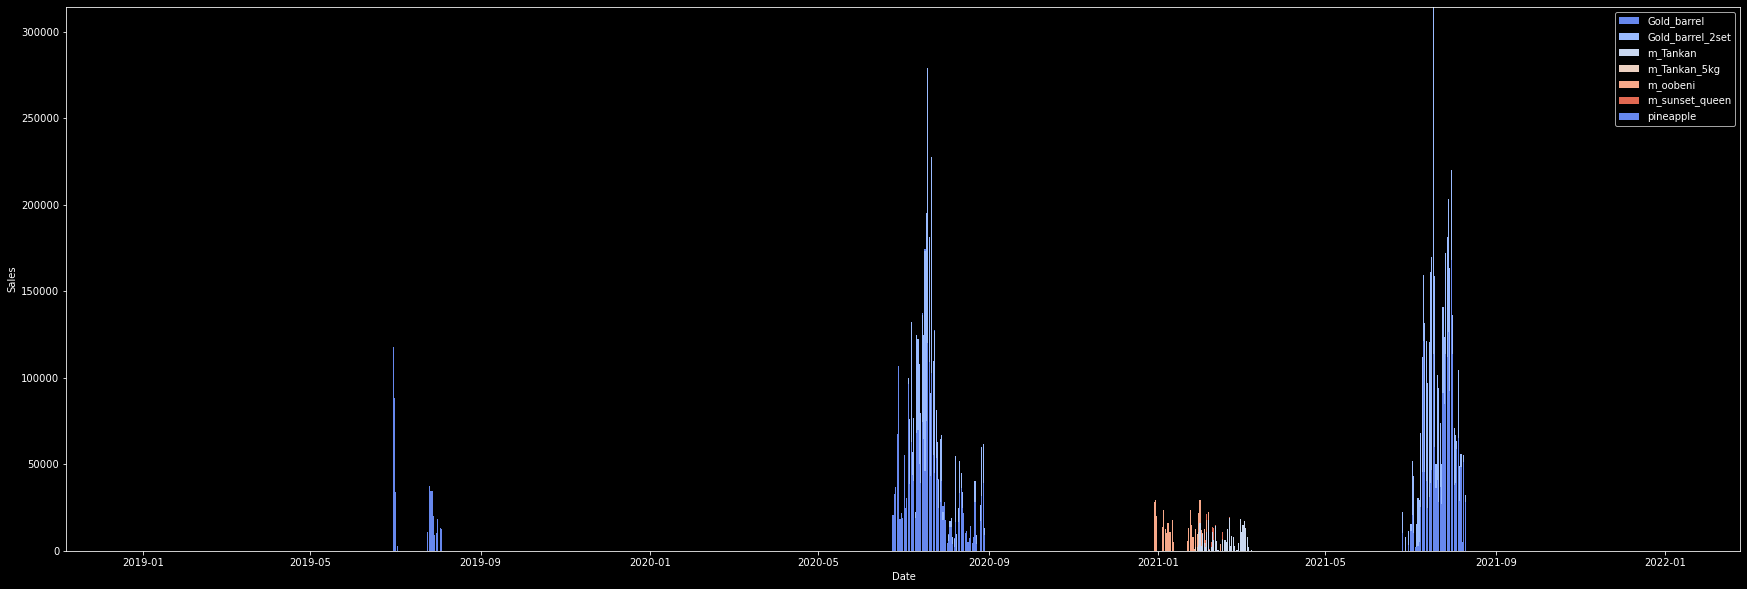

,Gold_barrel,Gold_barrel_2set,m_Tankan,m_Tankan_5kg,m_oobeni,m_sunset_queen,pineapple
ix,,,,,,,
2021-07-18,113474.0,200657.0,0.0,0.0,0.0,0.0,0.0


In [13]:
f_tsBar()

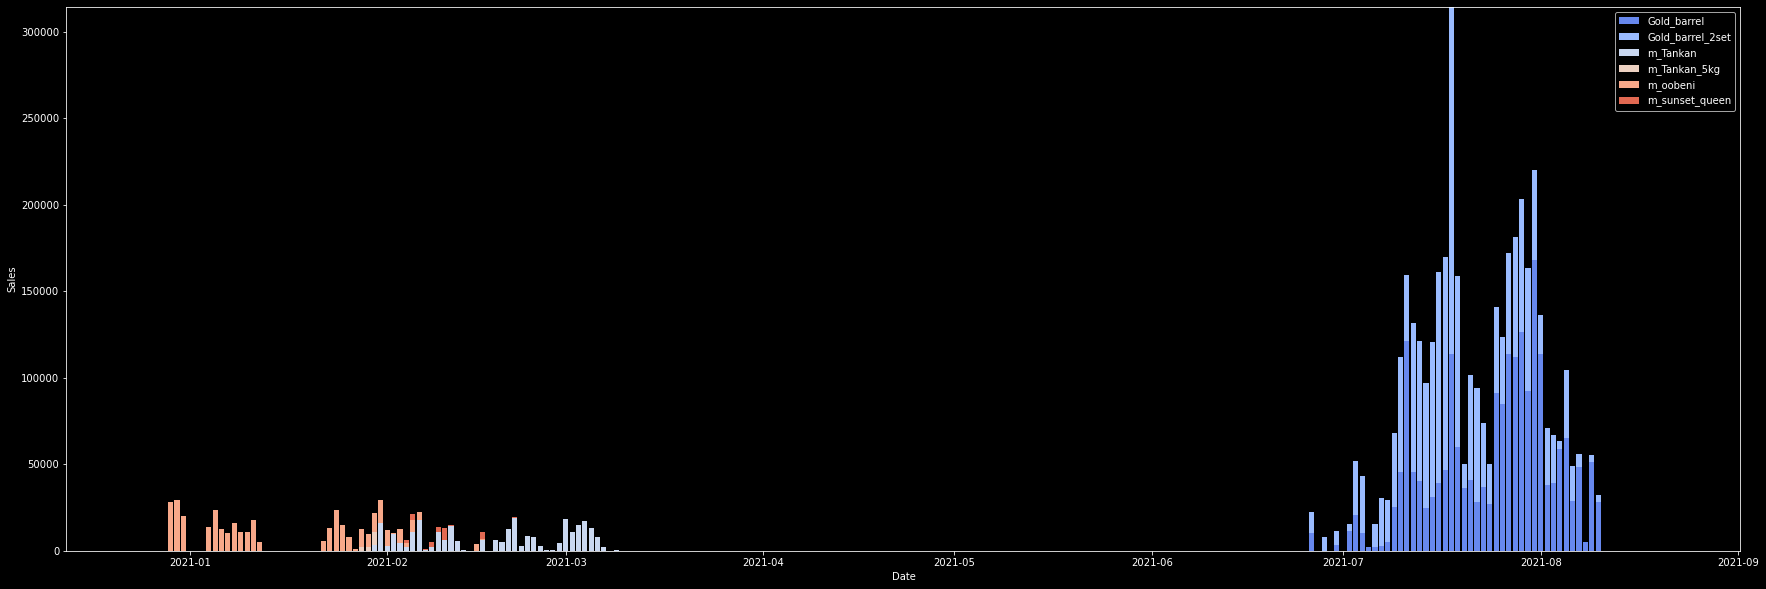

,Gold_barrel,Gold_barrel_2set,m_Tankan,m_Tankan_5kg,m_oobeni,m_sunset_queen
ix,,,,,,
2021-07-18,113474.0,200657.0,0.0,0.0,0.0,0.0


In [14]:
f_tsBar(period=['2020-12-25', '2021/8/20']) #

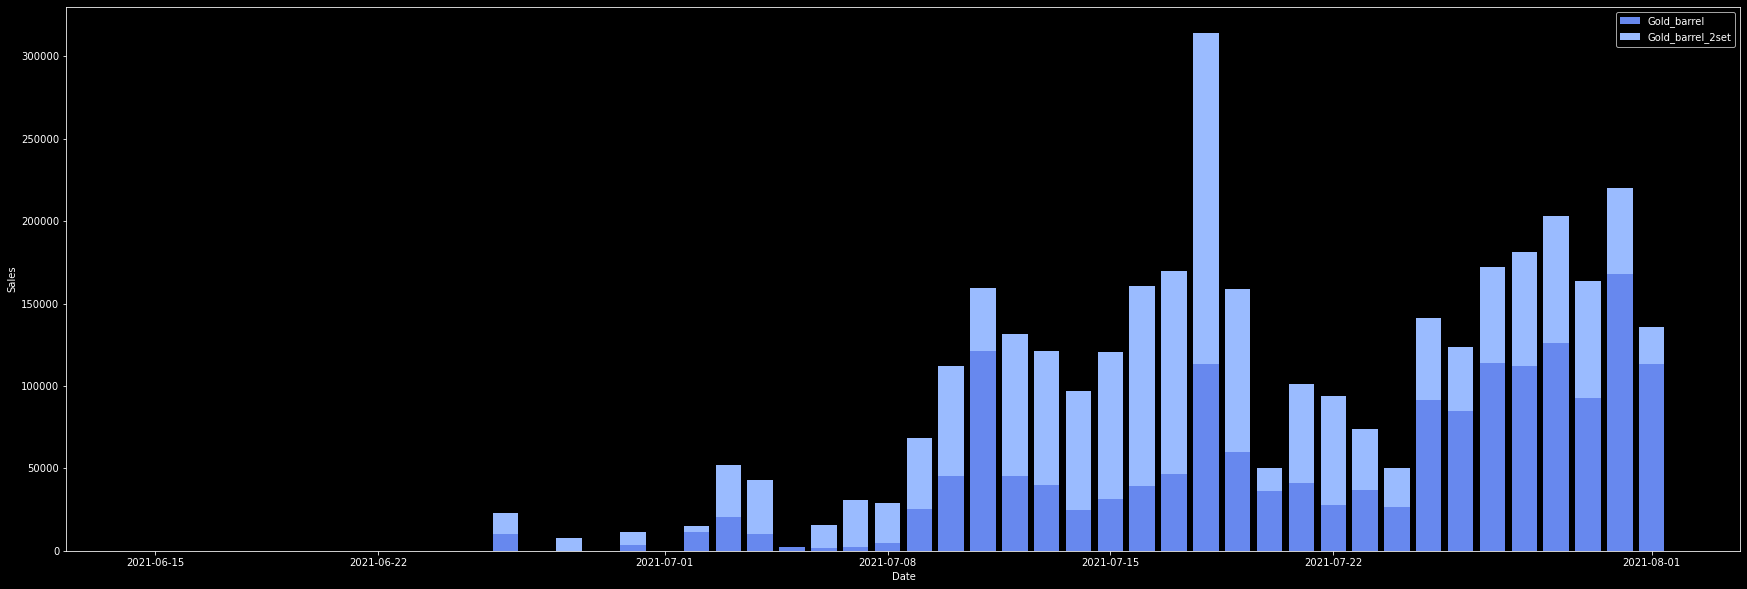

,Gold_barrel,Gold_barrel_2set
ix,,
2021-07-18,113474.0,200657.0


In [15]:
f_tsBar(period=['2021-6-15', '2021-8']) # df_pivotの値

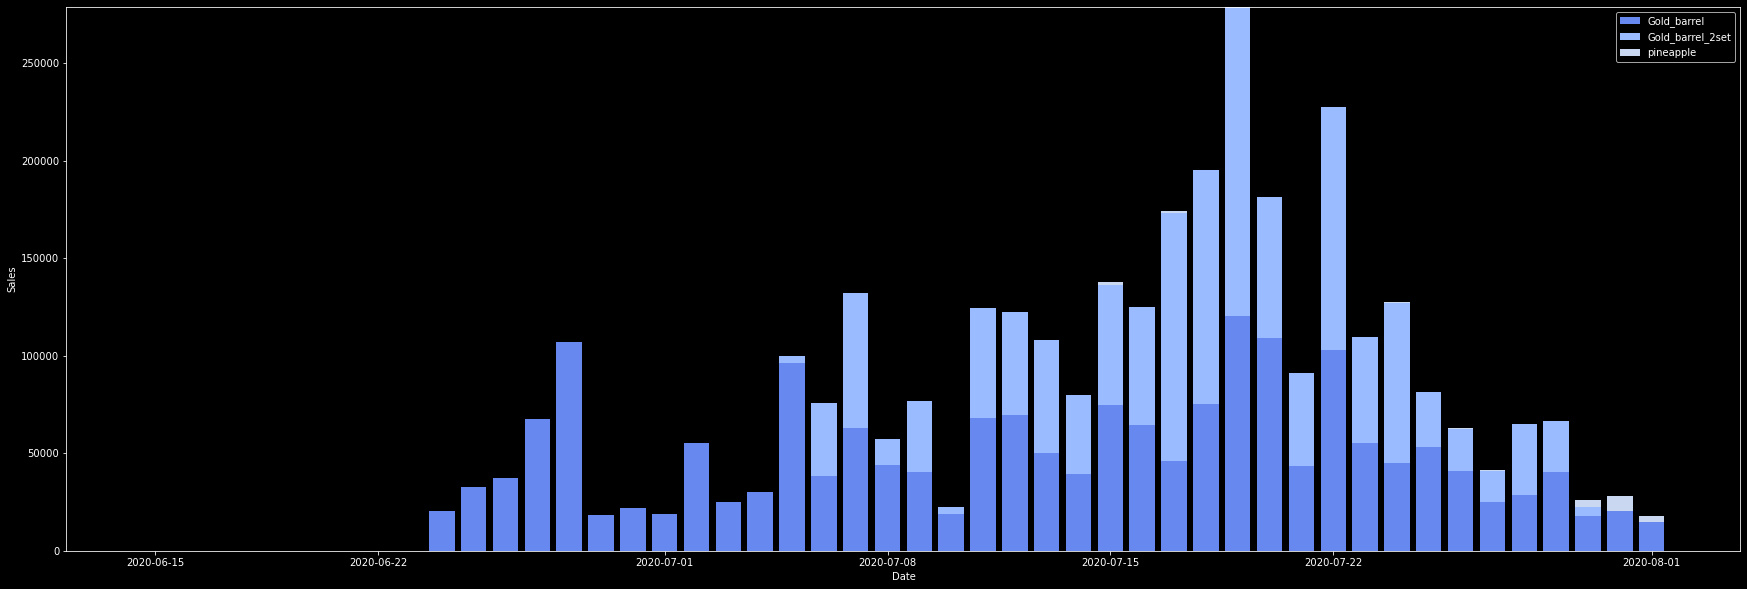

,Gold_barrel,Gold_barrel_2set,pineapple
ix,,,


In [16]:
f_tsBar(period=['2020-6-15', '2020-8']) # 返り値は df_pivot_1year

In [17]:
df1['2021-7-18':'2021-7-18'][['items2_en', 'quantity', 'ssCategory', 'pine_2set', 'I_price', 'F_sales', 'F_discount', 'F_dis_quantity', 'unit_quantity', 'last_message']]
# dfg_1day = pd.DataFrame(df1.groupby(['sent_dt', 'date', 'ssCategory']).sum()).reset_index().set_index(['sent_dt'])
# dfg_1day['2021-7-15':'2021-7-22']

# 56737 + 18650 + 25913 = 101300
print(56737 + 18650 + 25913 )
df1.groupby(['sent_dt', 'date', 'ssCategory', 'items2_en']).sum().reset_index().set_index(['sent_dt'])['2020-7-18':'2020-7-20'].drop(['F_dis_price', 'F_price', 'I_price'], axis=1)


101300


,date,ssCategory,items2_en,F_dis_quantity,F_discount,quantity,F_sales,I_sales,pine_2set,unit_weight_kg,unit_quantity
sent_dt,,,,,,,,,,,
2020-07-18 19:37:30,2020-07-18,パイン,Gold_barrel,0.0,0.0,62.0,75276.0,69250.0,0,14.90,62.0
2020-07-18 19:37:30,2020-07-18,パイン,Gold_barrel_2set,0.0,0.0,27.0,120096.0,110488.0,4,8.40,54.0
2020-07-19 19:37:21,2020-07-19,パイン,Gold_barrel,0.0,0.0,64.0,120204.0,110578.0,0,28.30,64.0
2020-07-19 19:37:21,2020-07-19,パイン,Gold_barrel_2set,0.0,0.0,35.0,158544.0,145858.0,4,8.40,70.0
2020-07-20 19:37:03,2020-07-20,パイン,Gold_barrel,0.0,0.0,63.0,109080.0,100350.0,0,12.00,63.0
2020-07-20 19:37:03,2020-07-20,パイン,Gold_barrel_2set,0.0,0.0,18.0,72144.0,66370.0,4,7.65,36.0


In [18]:
# fig, ax = plt.subplots(figsize=(20, 10))


dfp_quant = pd.DataFrame(df1['2021-6':'2021-8'].pivot_table(index='unit_weight_kg', columns='items2_en', values='unit_quantity', aggfunc=np.sum).unstack().reset_index())
dfp_quant = dfp_quant.set_index(['unit_weight_kg'])
dfp_quant.head()



df_weight = pd.DataFrame(df1['2021-6':'2021-8'].pivot_table(index='unit_weight_kg', columns='items2_en', values='unit_quantity', aggfunc=np.sum))
# pd.DataFrame(df1['2021-6':'2021-8'].pivot_table(index='unit_weight_kg', columns='items2_en', values='unit_quantity', aggfunc=np.sum)).plot(y=['Gold_barrel', 'Gold_barrel_2set'], kind='hist', stacked=True, alpha=0.6, figsize=(20, 10))


df_weight.reset_index(inplace=True)



<AxesSubplot:xlabel='unit_weight_kg'>

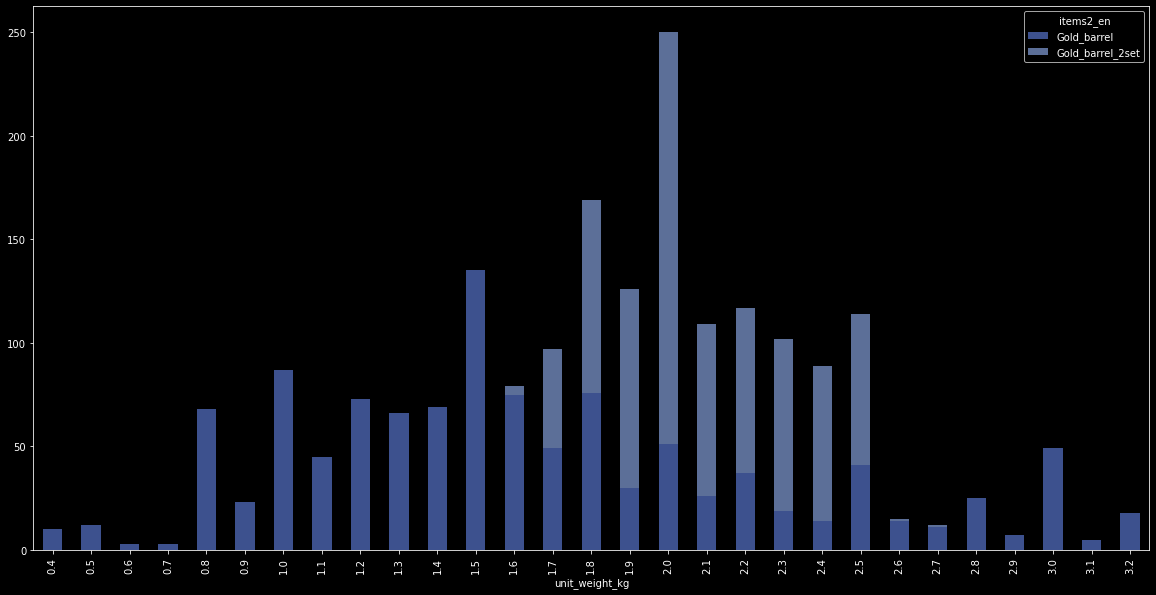

In [19]:
# dfp_quant.plot.bar(alpha=0.6, figsize=(20,10))

df_weight = pd.DataFrame(df1['2021-6':'2021-8'].pivot_table(index='unit_weight_kg', columns='items2_en', values='unit_quantity', aggfunc=np.sum))
df_weight.reset_index(inplace=True)

df_temp = df1.query('ssCategory=="パイン"')[['unit_weight_kg', 'items2_en', 'unit_quantity']]['2021-6':'2021-8']

# 2個セットを単品バラに分解した際、重量が少数第2位までになってしまった。例えば1.75の様に。
# しかし実際には100g刻みで値付け、販売した。そのため、個数を直近の整数値の上下に2分割して割り振る。
# 例えば1.75kg の場合、1.7kg 、 1.8kg の個数に1/2づつ割り振っている。
def f_distribute(x):
    w = x['unit_weight_kg'] * 10
    q = x['unit_quantity']
    # q = x['Gold_barrel_2set']
    if not w.is_integer(): 
        return [ w-0.5, w+0.5] , [ q/2, q/2 ]
    else:
        return w, q

df_temp[['unit_weight_kg', 'unit_quantity']] = df_temp.apply(lambda x: f_distribute(x), axis=1, result_type='expand') #.head(50)
df_temp = df_temp.explode(['unit_weight_kg', 'unit_quantity'])
df_temp = df_temp.astype({'unit_weight_kg':int, 'unit_quantity':int})
df_temp['unit_weight_kg'] = df_temp['unit_weight_kg'] / 10

df_temp = df_temp.pivot_table(index='unit_weight_kg', columns='items2_en', values='unit_quantity', aggfunc=np.sum)
df_temp.plot.bar(stacked=True, alpha=0.6, figsize=(20, 10))

### 単品の商品と箱に２個入ったセット商品の分布
2個セットの商品を単品として分解した時、
セット商品に用いたパインのサイズは主に1.6Kg〜2.5Kgのものだった。
パインは箱に収まるサイズでなければならないので。

(array([[ 10.,  12.,   3.,   3.,  68.,  23.,  87.,  45.,  73.,  66.,  69.,
         135.,  75.,  49.,  76.,  30.,  51.,  26.,  37.,  19.,  14.,  41.,
          14.,  11.,  25.,   7.,  49.,   5.,  18.],
        [ 10.,  12.,   3.,   3.,  68.,  23.,  87.,  45.,  73.,  66.,  69.,
         135.,  79.,  97., 169., 126., 250., 109., 117., 102.,  89., 114.,
          15.,  12.,  25.,   7.,  49.,   5.,  18.]]),
 array([0.4       , 0.49655172, 0.59310345, 0.68965517, 0.7862069 ,
        0.88275862, 0.97931034, 1.07586207, 1.17241379, 1.26896552,
        1.36551724, 1.46206897, 1.55862069, 1.65517241, 1.75172414,
        1.84827586, 1.94482759, 2.04137931, 2.13793103, 2.23448276,
        2.33103448, 2.42758621, 2.52413793, 2.62068966, 2.71724138,
        2.8137931 , 2.91034483, 3.00689655, 3.10344828, 3.2       ]),
 <a list of 2 BarContainer objects>)

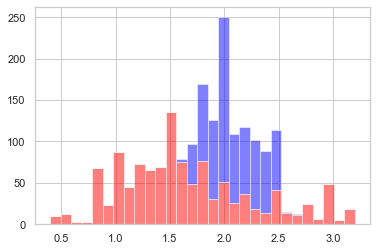

In [20]:

dfts_ = pd.DataFrame(df_temp.stack().reset_index()).rename(columns={0:'unit_quantity'})

dfts_.dtypes
def f_make_hist_list(x):
    return [1] * int(x)
def f_make_hist_list2(x):
    item1 = x['Gold_barrel']
    item2 = x['Gold_barrel_2set']
    return [f_make_hist_list(item1), f_make_hist_list(item2)]

dfts_['unit_quantity'] = dfts_['unit_quantity'].map(f_make_hist_list)
dfts_ = dfts_.explode(['unit_quantity'])
dfts_GB2set = dfts_.query('items2_en=="Gold_barrel_2set"')['unit_weight_kg']
dfts_GB = dfts_.query('items2_en=="Gold_barrel"')['unit_weight_kg']


sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')
plt.hist([dfts_GB, dfts_GB2set], bins=29, stacked=True, color=['red', 'blue'], alpha=0.5)

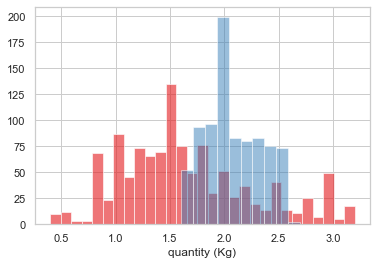

In [21]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.hist(dfts_GB, bins=29, alpha=0.6)
ax.hist(dfts_GB2set, alpha=0.5)
ax.set_xlabel('quantity (Kg)')
plt.show()

<AxesSubplot:xlabel='unit_weight_kg', ylabel='Density'>

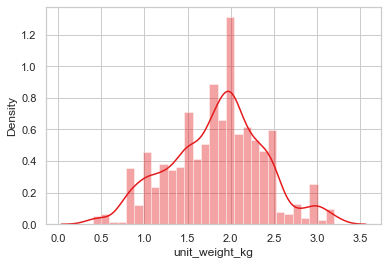

In [22]:
# 1年間に出荷したパイン。バラも2個セットも含めて。セットは分解済み。
sns.distplot(dfts_['unit_weight_kg'], bins=29, kde=True)

In [23]:

num = 17.5
(17.5).is_integer()
(17.0).is_integer()

[1] * 10


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
# 金額を見やすくするため、3桁区切りにしての表示

def f_summarize(df_period):
    cols = ['I_sales', 'F_sales', 'unit_quantity', 'F_discount']
    cols_jp = ['収　益　　　　　', 'ファーマーズ売上', '数　量　　　　　', '値引金額　　　　']
    cols_jp = dict(zip(cols, cols_jp))

    def accounting_num(temp):
        for c in temp.select_dtypes(include=float).columns:
            temp[c] = temp[c].apply('{:,.0f}'.format)
        return temp

    df_view = accounting_num(
        pd.DataFrame(
            df_period[cols].sum()
            ).rename(columns={0:'金額'})
        )

    df_view.rename(index=cols_jp, inplace=True)
    return df_view


In [25]:
# 冬の みかん の販売

df_period = df1['2020-12-28':'2021-3-10']
df_view = f_summarize(df_period)

print(f"\n---------- ---------- \n 2021年　冬の「みかん」の売上 \n---------- ---------- ")
print(df_view)
df_period.describe()


---------- ---------- 
 2021年　冬の「みかん」の売上 
---------- ---------- 
               金額
収　益　　　　　  596,621
ファーマーズ売上  648,603
数　量　　　　　      970
値引金額　　　　  -12,244


,F_dis_price,F_dis_quantity,F_discount,F_price,quantity,I_price,F_sales,I_sales,unit_weight_kg,unit_quantity
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,-9.037915,0.265403,-58.028436,967.151659,4.597156,899.052133,3073.947867,2827.587678,0.899052,4.597156
std,43.091138,1.605255,569.214010,827.427882,6.282538,764.821207,3403.386563,3131.073924,0.764821,6.282538
min,-388.000000,0.000000,-8148.000000,203.000000,1.000000,200.000000,216.000000,198.000000,0.200000,1.000000
25%,0.000000,0.000000,0.000000,324.000000,1.000000,300.000000,1003.500000,923.000000,0.300000,1.000000
50%,0.000000,0.000000,0.000000,486.000000,2.000000,400.000000,1998.000000,1838.000000,0.400000,2.000000
75%,0.000000,0.000000,0.000000,1836.000000,5.000000,1700.000000,3819.500000,3513.500000,1.700000,5.000000
max,0.000000,21.000000,0.000000,4320.000000,41.000000,4000.000000,19242.000000,17702.000000,4.000000,41.000000


In [26]:
# 夏の ゴールドバレル の販売

df_period = df1.loc['2021-6-25':'2021-8-15']
df_view = f_summarize(df_period)

print(f"\n---------- ---------- \n 2021年　夏の「パイン」の売上 \n---------- ---------- ")
print(df_view)
df_period.describe()


---------- ---------- 
 2021年　夏の「パイン」の売上 
---------- ---------- 
                 金額
収　益　　　　　  3,732,612
ファーマーズ売上  4,057,551
数　量　　　　　      1,977
値引金額　　　　   -132,615


,F_dis_price,F_dis_quantity,F_discount,F_price,quantity,I_price,F_sales,I_sales,unit_weight_kg,unit_quantity
count,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000,696.000000
mean,-65.001437,0.435345,-190.538793,2735.689655,2.239943,2533.045977,5829.814655,5362.948276,1.861638,2.840517
std,172.453998,1.061484,736.246669,1368.951092,1.876369,1267.547307,5424.344148,4990.409459,0.594230,2.368649
min,-1359.000000,0.000000,-8154.000000,432.000000,0.000000,400.000000,0.000000,0.000000,0.400000,0.000000
25%,0.000000,0.000000,0.000000,1512.000000,1.000000,1400.000000,2382.000000,2191.000000,1.400000,1.000000
50%,0.000000,0.000000,0.000000,2376.000000,1.000000,2200.000000,4204.000000,3867.500000,1.900000,2.000000
75%,0.000000,0.000000,0.000000,3996.000000,3.000000,3700.000000,7452.000000,6855.000000,2.250000,4.000000
max,0.000000,9.000000,0.000000,5724.000000,15.000000,5300.000000,39906.000000,36713.000000,3.200000,18.000000


### GmailのAPIからメールデータを取得するテスト



In [27]:
def test(query="is:read", tag="受信トレイ", count=3):

    """
    list GMail Inbox.

    Usage:
      listmail.py <query> <tag> <count>
      listmail.py -h | --help
      listmail.py --version

    Options:
      -h --help     Show this screen.
      --version     Show version.
    """
    import pickle
    import base64
    import json
    import io
    import csv
    import os.path
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow
    from google.auth.transport.requests import Request
    import base64
    from email.mime.text import MIMEText
    from apiclient import errors
    import logging
    from docopt import docopt
    from s0_gmail_credential import get_credential

    logger = logging.getLogger(__name__)


    def list_labels(service, user_id):
        """
        label のリストを取得する
        """
        labels = []
        response = service.users().labels().list(userId=user_id).execute()
        return response["labels"]


    def decode_base64url_data(data):
        """
        base64url のデコード
        """
        decoded_bytes = base64.urlsafe_b64decode(data)
        decoded_message = decoded_bytes.decode("UTF-8")
        return decoded_message


    def list_message(service, user_id, query, label_ids=[], count=3):
        """
        メールのリストを取得する

        Parameters
        ----------
        service : googleapiclient.discovery.Resource
            Gmail と通信するためのリソース
        user_id : str
            利用者のID
        query : str
            メールのクエリ文字列。 is:unread など
        label_ids : list
            検索対象のラベルを示すIDのリスト
        count : str
            リターンするメール情報件数の上限

        Returns
        ----------
        messages : list
            id, body, subject, from などのキーを持った辞書データのリスト
        """
        messages = []
        try:
            message_ids = (
                service.users()
                .messages()
                .list(userId=user_id, maxResults=count, q=query, labelIds=label_ids)
                .execute()
            )

            if message_ids["resultSizeEstimate"] == 0:
                logger.warning("no result data!")
                return []

            # message id を元に、message の内容を確認
            for message_id in message_ids["messages"]:
                message_detail = (
                    service.users()
                    .messages()
                    .get(userId="me", id=message_id["id"])
                    .execute()
                )
                message = {}
                message["id"] = message_id["id"]
                # 単純なテキストメールの場合
                if 'data' in message_detail['payload']['body']:
                    message["body"] = decode_base64url_data(
                        message_detail["payload"]["body"]["data"]
                    )
                # html メールの場合、plain/text のパートを使う
                else:
                    parts = message_detail['payload']['parts']
                    parts = [part for part in parts if part['mimeType'] == 'text/plain']
#                     message["body"] = decode_base64url_data(
#                         parts[0]['body']['data']
#                         )
                # payload.headers[name: "Subject"]
                message["subject"] = [
                    header["value"]
                    for header in message_detail["payload"]["headers"]
                    if header["name"] == "Subject"
                ][0]
                # payload.headers[name: "From"]
                message["from"] = [
                    header["value"]
                    for header in message_detail["payload"]["headers"]
                    if header["name"] == "From"
                ][0]
                logger.info(message_detail["snippet"])
                messages.append(message)
            return messages

        except errors.HttpError as error:
            print("An error occurred: %s" % error)


    def remove_labels(service, user_id, messages, remove_labels):
        """
        ラベルを削除する。既読にするために利用(is:unread ラベルを削除すると既読になる）
        """
        message_ids = [message["id"] for message in messages]
        labels_mod = {
            "ids": message_ids,
            "removeLabelIds": remove_labels,
            "addLabelIds": [],
        }
        # import pdb;pdb.set_trace()
        try:
            message_ids = (
                service.users()
                .messages()
                .batchModify(userId=user_id, body=labels_mod)
                .execute()
            )
        except errors.HttpError as error:
            print("An error occurred: %s" % error)


    # メイン処理
    def main(query="is:read", tag="受信トレイ", count=3):
        creds = get_credential()
        service = build("gmail", "v1", credentials=creds, cache_discovery=False)
        # ラベル一覧
        labels = list_labels(service, "me")
        target_label_ids = [label["id"] for label in labels if label["name"] == tag]
        # メール一覧 [{'body': 'xxx', 'subject': 'xxx', 'from': 'xxx'},]
        messages = list_message(service, "me", query, target_label_ids, count=count)
        # unread label
        unread_label_ids = [label["id"] for label in labels if label["name"] == "UNREAD"]
        # remove labels form messages
    #    remove_labels(service, "me", messages, remove_labels=unread_label_ids)
        logger.info(json.dumps(messages, ensure_ascii=False))
        if messages:
            return json.dumps(messages, ensure_ascii=False)
        else:
            return None


#     # プログラム実行部分
#     if __name__ == "__main__":
#         arguments = docopt(__doc__, version="0.1")
#         query = arguments["<query>"]
#         tag = arguments["<tag>"]
#         count = arguments["<count>"]
#         logging.basicConfig(level=logging.DEBUG)

    messages_ = main(query=query, tag=tag, count=count)
    print(messages_)
    print("########## ########## ########## ########## ##########")




In [28]:
test(query='subject:売上')

RefreshError: ('invalid_grant: Bad Request', {'error': 'invalid_grant', 'error_description': 'Bad Request'})